Global COVID-19 Vaccination
Analysis: SQL & Trend Visualization

"Testing if high-vaccination countries have daily higher vaccinations"

In [ ]:

import pandas as pd
import sqlite3

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

Load Dataset

In [ ]:


url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv"
df = pd.read_csv(url)

# Inspect dataset
df.head()

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,33.0,1367.0,0.003
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,33.0,1367.0,0.003
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,33.0,1367.0,0.003
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,33.0,1367.0,0.003


Data Cleaning

In [ ]:

df = df[['location','date','total_vaccinations','people_vaccinated','people_fully_vaccinated','daily_vaccinations']]

# Drop rows where location is "World" or continents
df = df[~df['location'].isin(['World','Africa','Asia','Europe','European Union','North America','Oceania','South America'])]

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Fill missing values with 0 for simplicity
df.fillna(0, inplace=True)

# Flag top-vaccinated countries for A/B-style analysis
df['high_vaccination'] = df['people_fully_vaccinated'] > 1_000_000

Create SQLite Database

In [ ]:

conn = sqlite3.connect('covid_vaccination.db')
df.to_sql('vaccinations', conn, if_exists='replace', index=False)

186029

SQL Queries

In [ ]:
query_total_vax = """
SELECT location, MAX(total_vaccinations) AS total_vaccinations
FROM vaccinations
GROUP BY location
ORDER BY total_vaccinations DESC
LIMIT 10;
"""
pd.read_sql(query_total_vax, conn)

Average Daily Vaccinations

In [ ]:
query_avg_daily = """
SELECT location, ROUND(AVG(daily_vaccinations),0) AS avg_daily_vaccinations
FROM vaccinations
GROUP BY location
ORDER BY avg_daily_vaccinations DESC
LIMIT 10;
"""
pd.read_sql(query_avg_daily, conn)

,location,avg_daily_vaccinations
0,China,4434381.0
1,Upper middle income,4067036.0
2,Lower middle income,3780659.0
3,High income,2097325.0
4,India,1690154.0
5,United States,770789.0
6,Brazil,611879.0
7,Japan,473758.0
8,Indonesia,428527.0
9,Mexico,338279.0


A/B Style: High vs Low Vaccinated Countries

In [ ]:
query_ab = """
SELECT high_vaccination AS group_label,
       COUNT(*) AS total_days,
       ROUND(AVG(daily_vaccinations),0) AS avg_daily_vaccinations,
       ROUND(MAX(total_vaccinations)/1000000,2) AS max_vaccinations_millions
FROM vaccinations
GROUP BY group_label;
"""
pd.read_sql(query_ab, conn)

,group_label,total_days,avg_daily_vaccinations,max_vaccinations_millions
0,0,137465,44733.0,3488.06
1,1,48564,435410.0,5449.98


Visualizations

/tmp/ipython-input-3289137262.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_vaccinations', y='location', data=top10, palette="Blues_d")


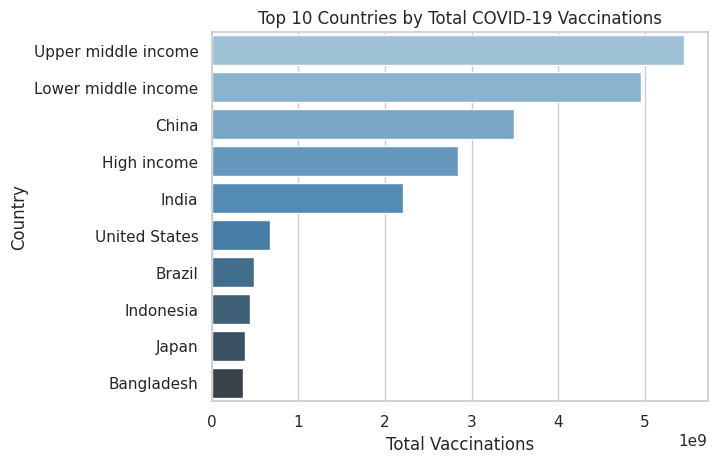

In [ ]:
query_total_vax = """
SELECT location, MAX(total_vaccinations) AS total_vaccinations
FROM vaccinations
GROUP BY location
ORDER BY total_vaccinations DESC
LIMIT 10;
"""
top10 = pd.read_sql(query_total_vax, conn)
sns.barplot(x='total_vaccinations', y='location', data=top10, palette="Blues_d")
plt.xlabel("Total Vaccinations")
plt.ylabel("Country")
plt.title("Top 10 Countries by Total COVID-19 Vaccinations")
plt.show()

Average Daily Vaccinations (1)

/tmp/ipython-input-2870173394.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_daily_vaccinations', y='location', data=avg_daily, palette="Greens_d")


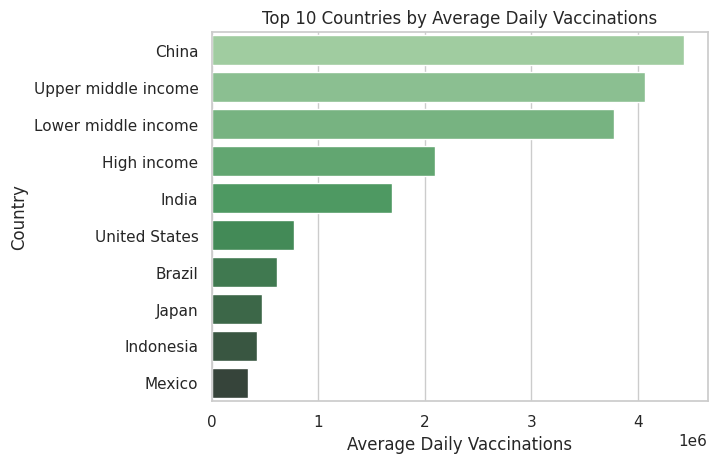

In [ ]:
avg_daily = pd.read_sql(query_avg_daily, conn)
sns.barplot(x='avg_daily_vaccinations', y='location', data=avg_daily, palette="Greens_d")
plt.xlabel("Average Daily Vaccinations")
plt.ylabel("Country")
plt.title("Top 10 Countries by Average Daily Vaccinations")
plt.show()

A/B Style Comparison

/tmp/ipython-input-1624507636.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='group_label', y='avg_daily_vaccinations', data=ab_data, palette="Oranges_d")


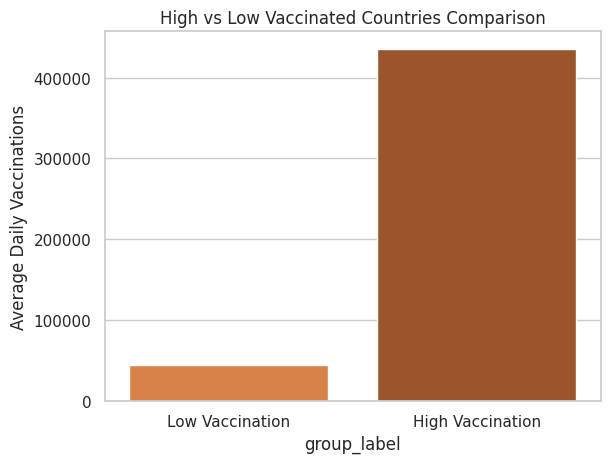

In [ ]:
ab_data = pd.read_sql(query_ab, conn)
ab_data['group_label'] = ab_data['group_label'].map({1:'High Vaccination', 0:'Low Vaccination'})
sns.barplot(x='group_label', y='avg_daily_vaccinations', data=ab_data, palette="Oranges_d")
plt.ylabel("Average Daily Vaccinations")
plt.title("High vs Low Vaccinated Countries Comparison")
plt.show()